In [23]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

from sklearn.metrics import classification_report
from src.utils import plot_confusion_matrix, line_label_id2label, line_Label_label2id, performance_metrics, plot_embeddings, get_df_classificationreport

import torch

# MedBERT Finetune on Lines

In [29]:
# results = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_LORA_class_finetuned.pt")
results = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_finetuned.pt")
labels = results["labels"]
last_hidden_state = results["last_hidden_state"]
preds = results["preds"]

In [30]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

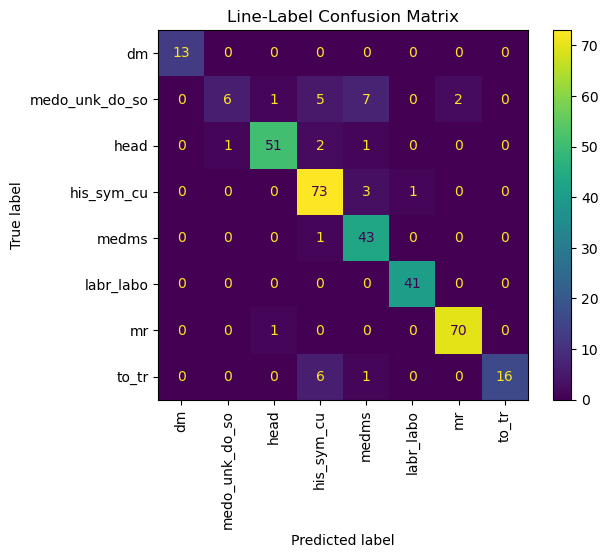

In [31]:
plot_confusion_matrix(preds=preds, labels=labels, title="Line-Label Confusion Matrix", label2id=line_Label_label2id)

In [32]:
y_valid = [line_label_id2label[label] for label in labels]
y_pred = [line_label_id2label[pred] for pred in preds]
get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values()))

,eval_measure,precision,recall,f1-score,support
0,dm,1.000000,1.000000,1.000000,13
1,head,0.962264,0.927273,0.944444,55
2,his_sym_cu,0.839080,0.948052,0.890244,77
3,labr_labo,0.976190,1.000000,0.987952,41
4,medms,0.781818,0.977273,0.868687,44
5,medo_unk_do_so,0.857143,0.285714,0.428571,21
6,mr,0.972222,0.985915,0.979021,71
7,to_tr,1.000000,0.695652,0.820513,23
8,accuracy,NaN,NaN,0.907246,345
9,macro avg,0.923590,0.852485,0.864929,345


(345, 2)


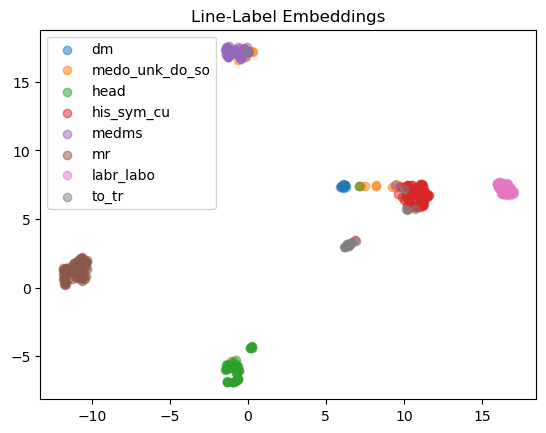

In [33]:
plot_embeddings(embeddings, [line_label_id2label[label] for label in labels], title="Line-Label Embeddings", method="umap", )

# MedBERT Token Classification

In [54]:
results = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_finetuned.pt")
# results = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_LORA_token_finetuned.pt")

In [42]:
from itertools import chain

In [43]:
labels = list(chain(*results["labels"]))
preds = list(chain(*results["preds"]))

In [53]:
len(results["labels"][2]), len(results["text"][2])

(20, 36)

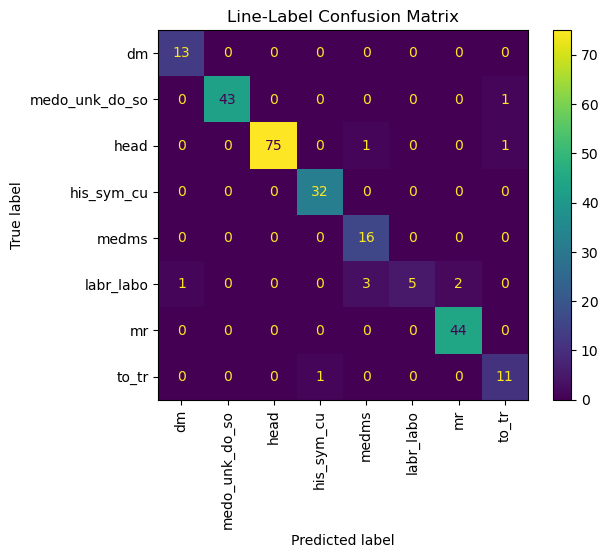

In [46]:
plot_confusion_matrix(preds=preds, labels=labels, title="Line-Label Confusion Matrix", label2id=line_Label_label2id)

In [47]:
get_df_classificationreport(labels, preds, labels = sorted(line_label_id2label.values()))

,eval_measure,precision,recall,f1-score,support
0,dm,0.928571,1.000000,0.962963,13
1,head,1.000000,0.977273,0.988506,44
2,his_sym_cu,1.000000,0.974026,0.986842,77
3,labr_labo,0.969697,1.000000,0.984615,32
4,medms,0.800000,1.000000,0.888889,16
5,medo_unk_do_so,1.000000,0.454545,0.625000,11
6,mr,0.956522,1.000000,0.977778,44
7,to_tr,0.846154,0.916667,0.880000,12
8,accuracy,NaN,NaN,0.959839,249
9,macro avg,0.937618,0.915314,0.911824,249
